In [1]:
from code.dataviz import data_slice,data_timeplot,mape,smape
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

# PROPHET MODEL for solving dynamic profile forecasting challenge

In [2]:
from fbprophet import Prophet
import numpy as np

X_train=pd.read_csv('..\\..\\..\\datasets\\training_input_qFI2jug.csv', index_col="Horodate_UTC",parse_dates=['Horodate_UTC'], dayfirst=True)
X_train.index = pd.DatetimeIndex(X_train.index)

In [3]:
X_test=pd.read_csv('..\\..\\..\\datasets\\testing_input_BcjTmnd.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#X_test['timestamp']=pd.to_datetime(X_test.index)
X_test.index = pd.DatetimeIndex(X_test.index)

X_test['timestamp']=pd.to_datetime(X_test.index)

In [ ]:
y_train=pd.read_csv('..\\..\\..\\datasets\\training_output_uamzSZW.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#y_train['timestamp']=pd.to_datetime(y_train.index)
y_train.index = pd.DatetimeIndex(y_train.index)

y_train['timestamp']=pd.to_datetime(y_train.index)

# dataset preparation for prophet interface

Prophet model requires a minimum of 2 columns matching the timeserie strucuture :
- column 'ds' contains the timestamp of the serie
- column 'y' contains the value of the serie
So the index of the original dataset y_train

In [4]:
# # copy of y_train dataset with renaming of the 'RES11_BASE' column in 'y'
# y_RES11_BASE=y_train.rename(columns={'RES11_BASE':'y'})
# # creation of 'ds' column and copy of the initial dataset index
# y_RES11_BASE['ds']=y_RES11_BASE.index
y_RES11_BASE = pd.DataFrame(index=y_train.index)
y_RES11_BASE['ds'] = y_train.index
y_RES11_BASE['y'] = y_train['RES11_BASE']
y_RES11_BASE.head()

,ds,y
Horodate_UTC,,
2013-10-13 22:00:00,2013-10-13 22:00:00,0.698925
2013-10-13 22:30:00,2013-10-13 22:30:00,0.722778
2013-10-13 23:00:00,2013-10-13 23:00:00,0.678717
2013-10-13 23:30:00,2013-10-13 23:30:00,0.668509
2013-10-14 00:00:00,2013-10-14 00:00:00,0.700487


# Model evaluation over complete training period with default settings

In [5]:
# model creation and fitting over the trainin period till (30/04/2017)
prophet=Prophet()
prophet.fit(y_RES11_BASE.loc[:date(2017,4,30)])


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


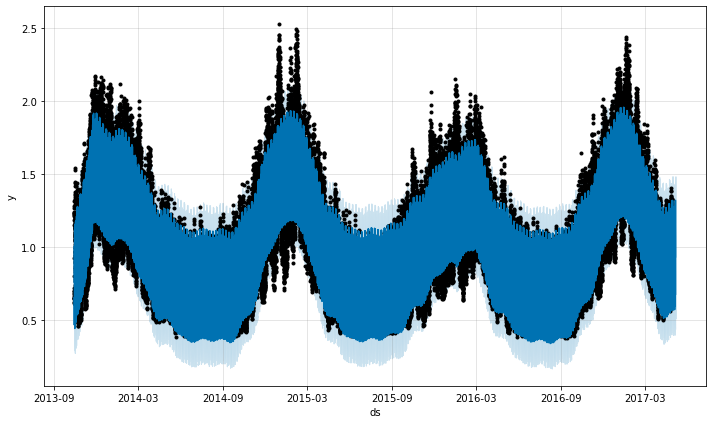

In [6]:
m=prophet
# creation of the future dataset that will include 7 day of forecast
# this 7 days period is passed to the by giving the frequence (30 minutes) and the number of samples 7*48
future = m.make_future_dataframe(periods=7*48, freq = '30T')
# creation of forecast dataset that will collect all the predcited value and the decomposition
forecast = m.predict(future)
fig = m.plot(forecast)

## results analysis
- resusults are stored in the forecast dataset wich contains severals columns as it is shown below
- 'yhat' contains $ \hat{y}$  the estimated values at the datetime index contained in 'ds'
- results are the plotted by extracting samples conatined in forecast dataset matching the period 7*48

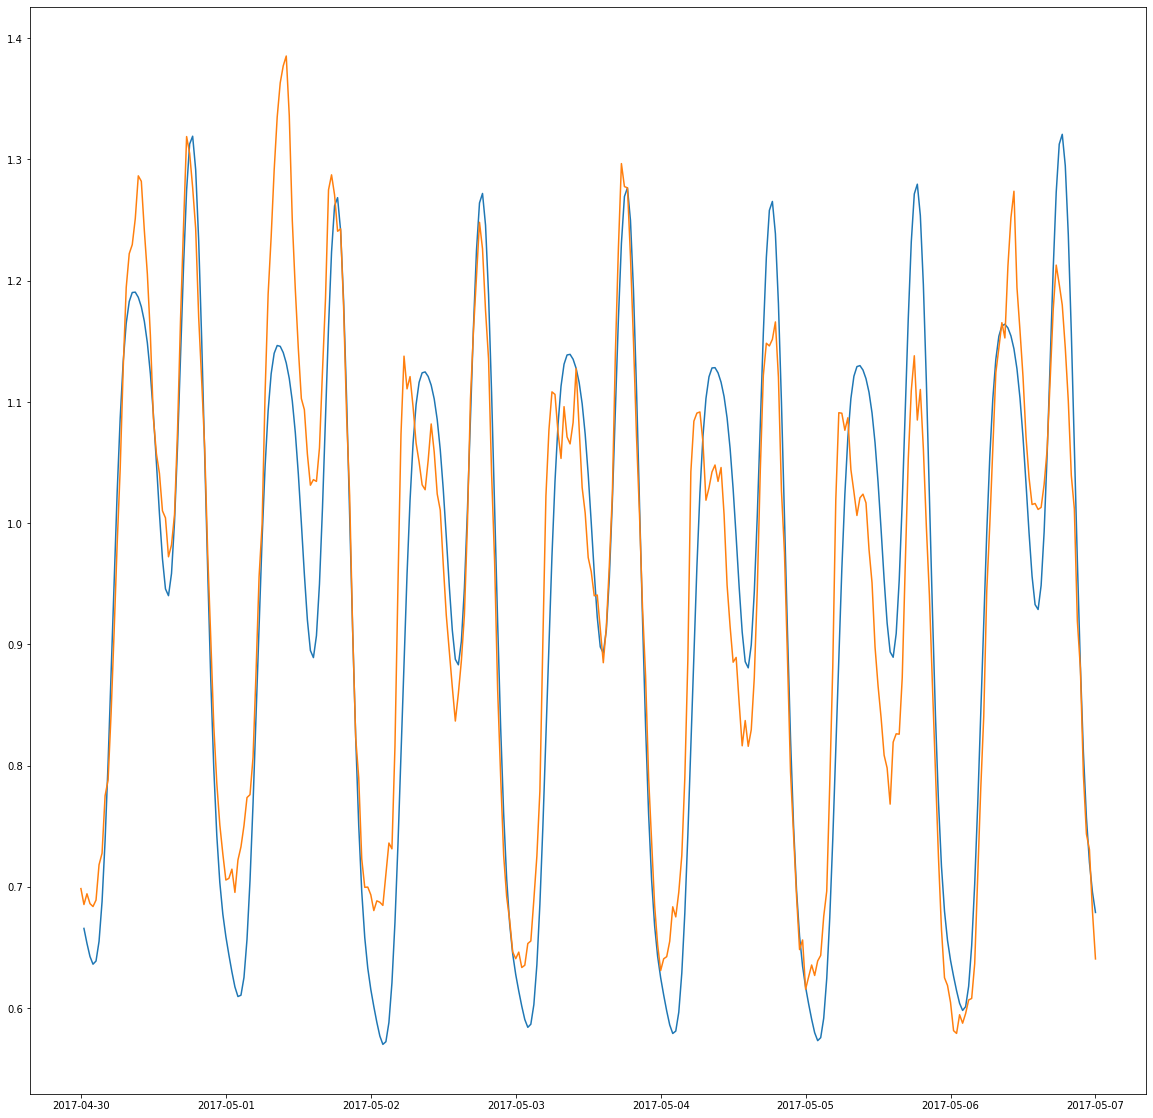

In [7]:
fig=plt.figure(figsize=(20,20))
id_max=forecast.shape[0]
# forecasted values ared stored at index contained in the index range [ id_max-(7*48+1) : id_max ]

plt.plot_date(forecast.iloc[id_max-7*48:id_max]['ds'],forecast.iloc[id_max-7*48:id_max]['yhat'],linestyle='-',marker=None)
plt.plot_date(y_train.loc[date(2017,4,30):date(2017,5,7)].index,y_train.loc[date(2017,4,30):date(2017,5,7)]['RES11_BASE'],linestyle='-',marker=None)
#plt.axvline(x=date(2017,4,30),color='green')

## Performance evaluation

In [8]:
from statsmodels.tools.eval_measures import rmse

Evaluation of the model with RMSE and MAPE metrics

In [9]:
# computation of metrics over the forecasted period using relative index from the end of the serie (id_max)
print('RMSE',rmse(forecast.iloc[id_max-(7*48+1):id_max]['yhat'],y_train.loc[date(2017,4,30):date(2017,5,7)]['RES11_BASE']))

print('MAPE %0.2f%%' %mape(np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES11_BASE']), np.array(forecast.iloc[id_max-(7*48+1):id_max]['yhat'])))

RMSE 0.08653790058656023
MAPE 7.29%


# Introduction of seasonality

Following seasonality are introduced into the model

- working day / non  working day seasonality
- winter summer seasonality

A regressor is also added
- temperature regressor

In [10]:
#creation of the new dataset which contain new columns containing seasonality booleans
from code.seasons import seasonalize
arguments = {'mixed_columns': True, 'merge': True, 'pentecote': False, 'extradayoff': True, 
             'events' : {'world_cup_2014': ['12/06/2014', '13/07/2014'], 'rentree_2014': '02/09/2014', 'rentree_2015': '01/09/2015', 
                         'euro_cup_2016': ['10/06/2016', '10/07/2016'], 'rentree_2016': '01/09/2016', 'rentree_2017': '04/09/2017', 
                         'rentree_2018': '03/09/2018', 'world_cup_2018': ['14/06/2018', '15/07/2018']}}

df = seasonalize(y_RES11_BASE.loc[:date(2017,4,30)], **arguments).seasons_dataset()
df.special_days = df.special_days.astype(int)

In [11]:
df.tail()

,special_days,offpeak,peak,ds,y,winter_on_work,winter_off_work,summer_on_work,summer_off_work
Horodate_UTC,,,,,,,,,
2017-04-29 22:00:00,0,False,True,2017-04-29 22:00:00,0.840376,False,False,False,True
2017-04-29 22:30:00,0,False,True,2017-04-29 22:30:00,0.766005,False,False,False,True
2017-04-29 23:00:00,0,False,True,2017-04-29 23:00:00,0.743610,False,False,False,True
2017-04-29 23:30:00,0,False,True,2017-04-29 23:30:00,0.727882,False,False,False,True
2017-04-30 00:00:00,0,False,True,2017-04-30 00:00:00,0.698508,False,False,False,True


## Regressor is added to the dataset

In [12]:
# copy of the temperature (columns 18 from X_train) is added to the dataset in column 'temp'
df['temp'] = X_train.iloc[0:,19:20]

df.head()

,special_days,offpeak,peak,ds,y,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
Horodate_UTC,,,,,,,,,,
2013-10-13 22:00:00,0,False,True,2013-10-13 22:00:00,0.698925,False,False,False,True,13.5
2013-10-13 22:30:00,0,False,True,2013-10-13 22:30:00,0.722778,False,False,False,True,13.5
2013-10-13 23:00:00,0,False,True,2013-10-13 23:00:00,0.678717,False,False,False,True,13.5
2013-10-13 23:30:00,0,False,True,2013-10-13 23:30:00,0.668509,False,False,False,True,13.5
2013-10-14 00:00:00,0,False,True,2013-10-14 00:00:00,0.700487,False,False,True,False,13.5


In [13]:
def weather_temp(df):
    columns = list(X_train.columns.values.tolist()) 
    if isinstance(df.index, pd.DatetimeIndex):
        list_date = df.index.tolist()
        count = 0
        for d in list_date:
            df.at[d, 'temp'] = X_train.loc[d,columns[19]]
            count = count + 1
    return df

## Creation of the Prophet model with custom seasonality an regressor
internal daily seasonality is desactivated

In [14]:
m = Prophet(daily_seasonality=False)

m.add_seasonality(name='winter_on_work', period=1, fourier_order=12, condition_name='winter_on_work')
m.add_seasonality(name='winter_off_work', period=1, fourier_order=12, condition_name='winter_off_work')
m.add_seasonality(name='summer_on_work', period=1, fourier_order=12, condition_name='summer_on_work')
m.add_seasonality(name='summer_off_work', period=1, fourier_order=12, condition_name='summer_off_work')

m.add_regressor(name='temp')
m.add_regressor(name='special_days')
# m.add_regressor(name='offpeak_hours')

Model training

In [15]:
m.fit(df)


### Preparation of future dataset for the forecast
creation of the seasonality and regressors columns

In [16]:
future = m.make_future_dataframe(periods=7*48, freq = '30T')

future['id']=future.index
future.index=future['ds']

future=seasonalize(future, **arguments).seasons_dataset()
future.special_days = future.special_days.astype(int)

future = weather_temp(future)
future.head()

# calendar.Dataframe(future)
# future=calendar.prophet_days_onoff()
future.index=future['id']
future=future.drop(["id"],axis=1)
future.head()

,special_days,offpeak,peak,ds,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
id,,,,,,,,,
0,0,False,True,2013-10-13 22:00:00,False,False,False,True,13.5
1,0,False,True,2013-10-13 22:30:00,False,False,False,True,13.5
2,0,False,True,2013-10-13 23:00:00,False,False,False,True,13.5
3,0,False,True,2013-10-13 23:30:00,False,False,False,True,13.5
4,0,False,True,2013-10-14 00:00:00,False,False,True,False,13.5


## Forecast calculation
results are the plotted :
- components of the forecast :  trend, yealry seasonality, weekly seasonality, daily custom sesonality, regressor
- forecasted serie

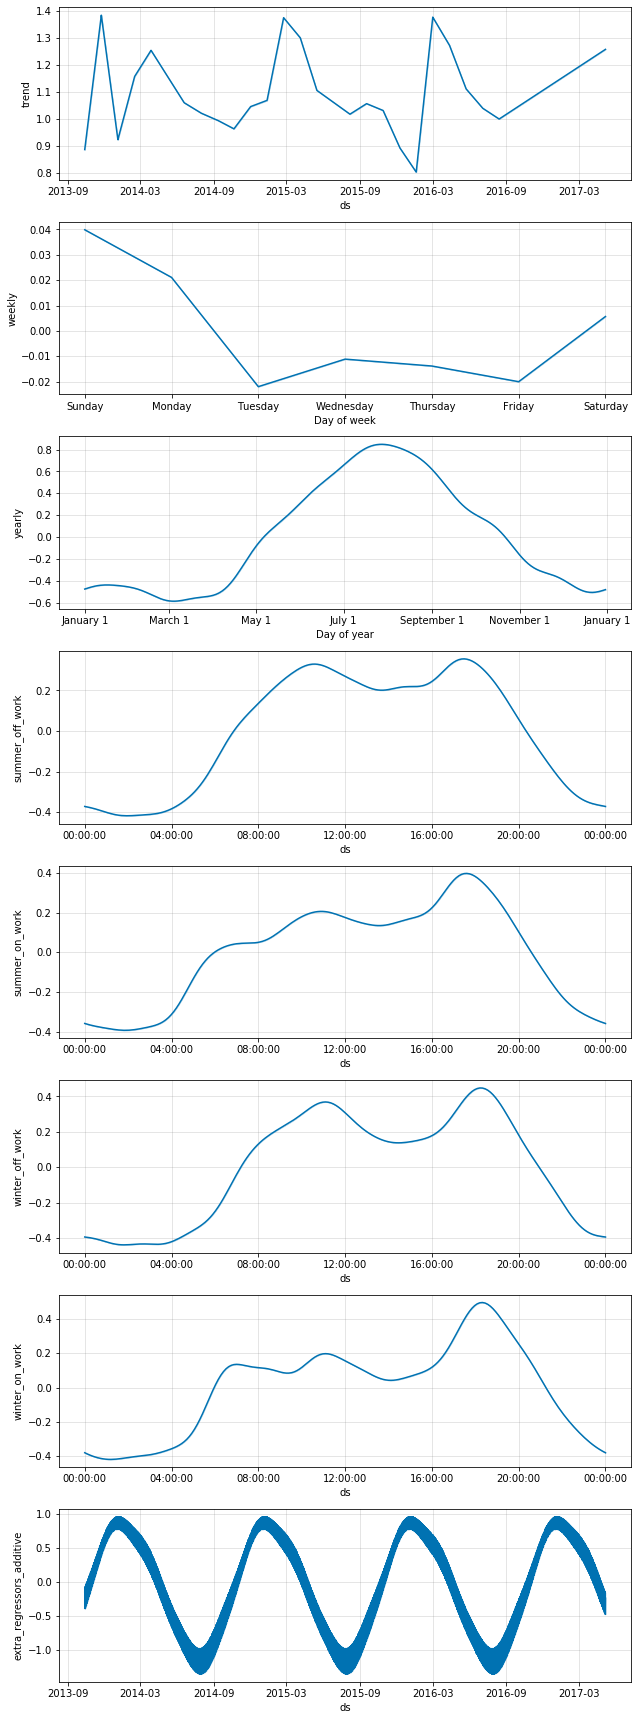

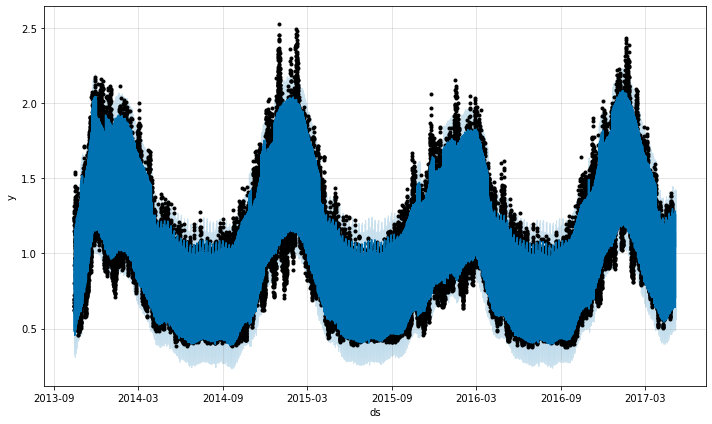

In [17]:

forecast = m.predict(future)

fig = m.plot_components(forecast)

fig = m.plot(forecast)

# Focus on the forecast and model evaluation

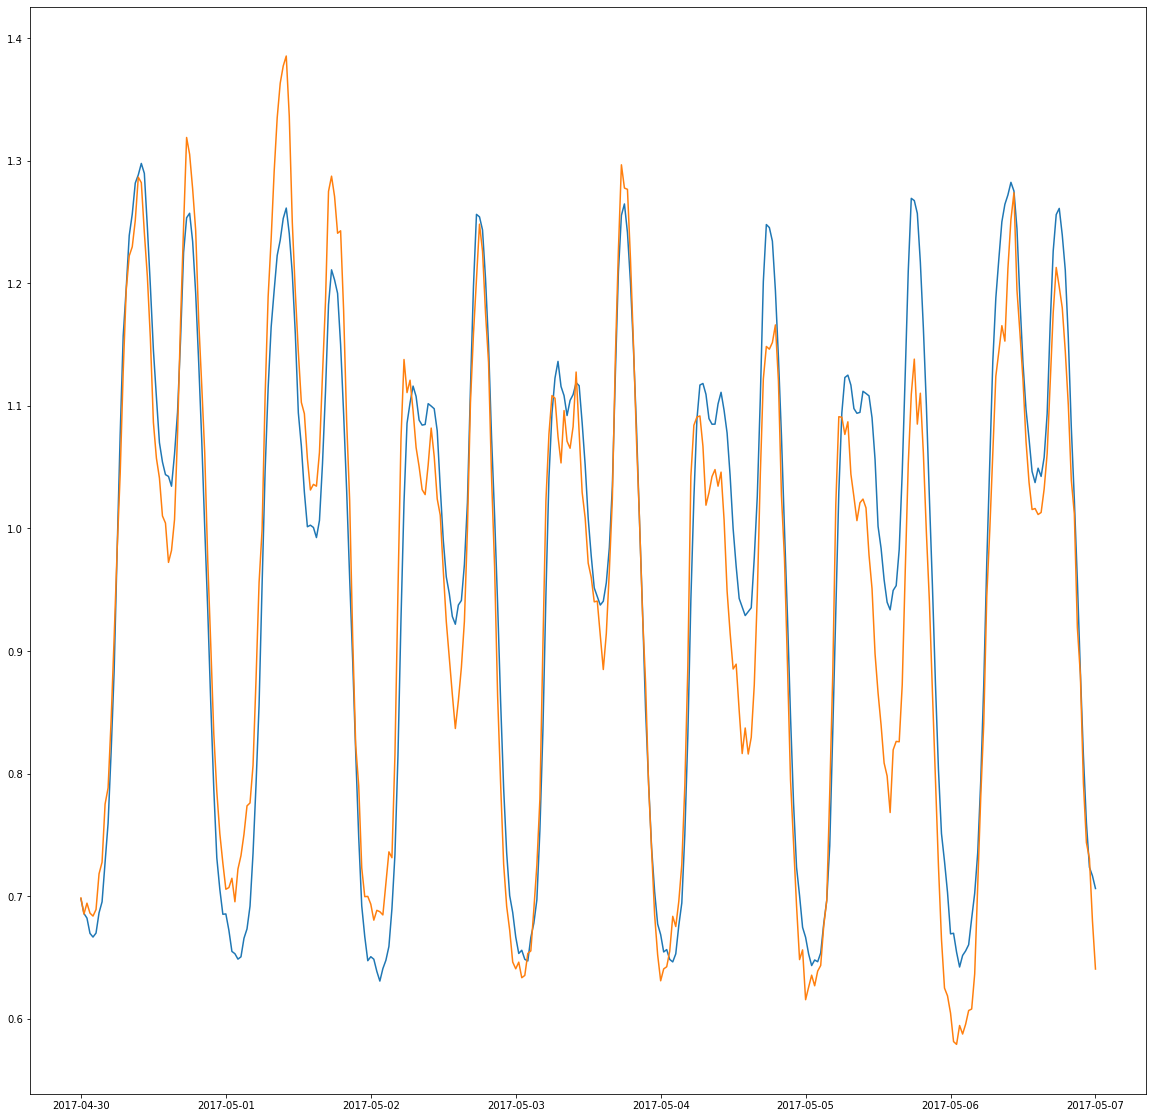

In [18]:
fig=plt.figure(figsize=(20,20))
id_max=forecast.shape[0]
plt.plot_date(forecast.iloc[id_max-(7*48+1):id_max]['ds'],forecast.iloc[id_max-(7*48+1):id_max]['yhat'],linestyle='-',marker=None)
plt.plot_date(y_train.loc[date(2017,4,30):date(2017,5,7)].index,y_train.loc[date(2017,4,30):date(2017,5,7)]['RES11_BASE'],linestyle='-',marker=None)

In [19]:
print('RMSE',rmse(forecast.iloc[id_max-(7*48+1):id_max]['yhat'],y_train.loc[date(2017,4,30):date(2017,5,7)]['RES11_BASE']))

print('MAPE %0.2f%%' %mape(np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES11_BASE']), np.array(forecast.iloc[id_max-(7*48+1):id_max]['yhat'])))

RMSE 0.06457498356740396
MAPE 5.72%


# Comparison of forecasted and real daily profiles

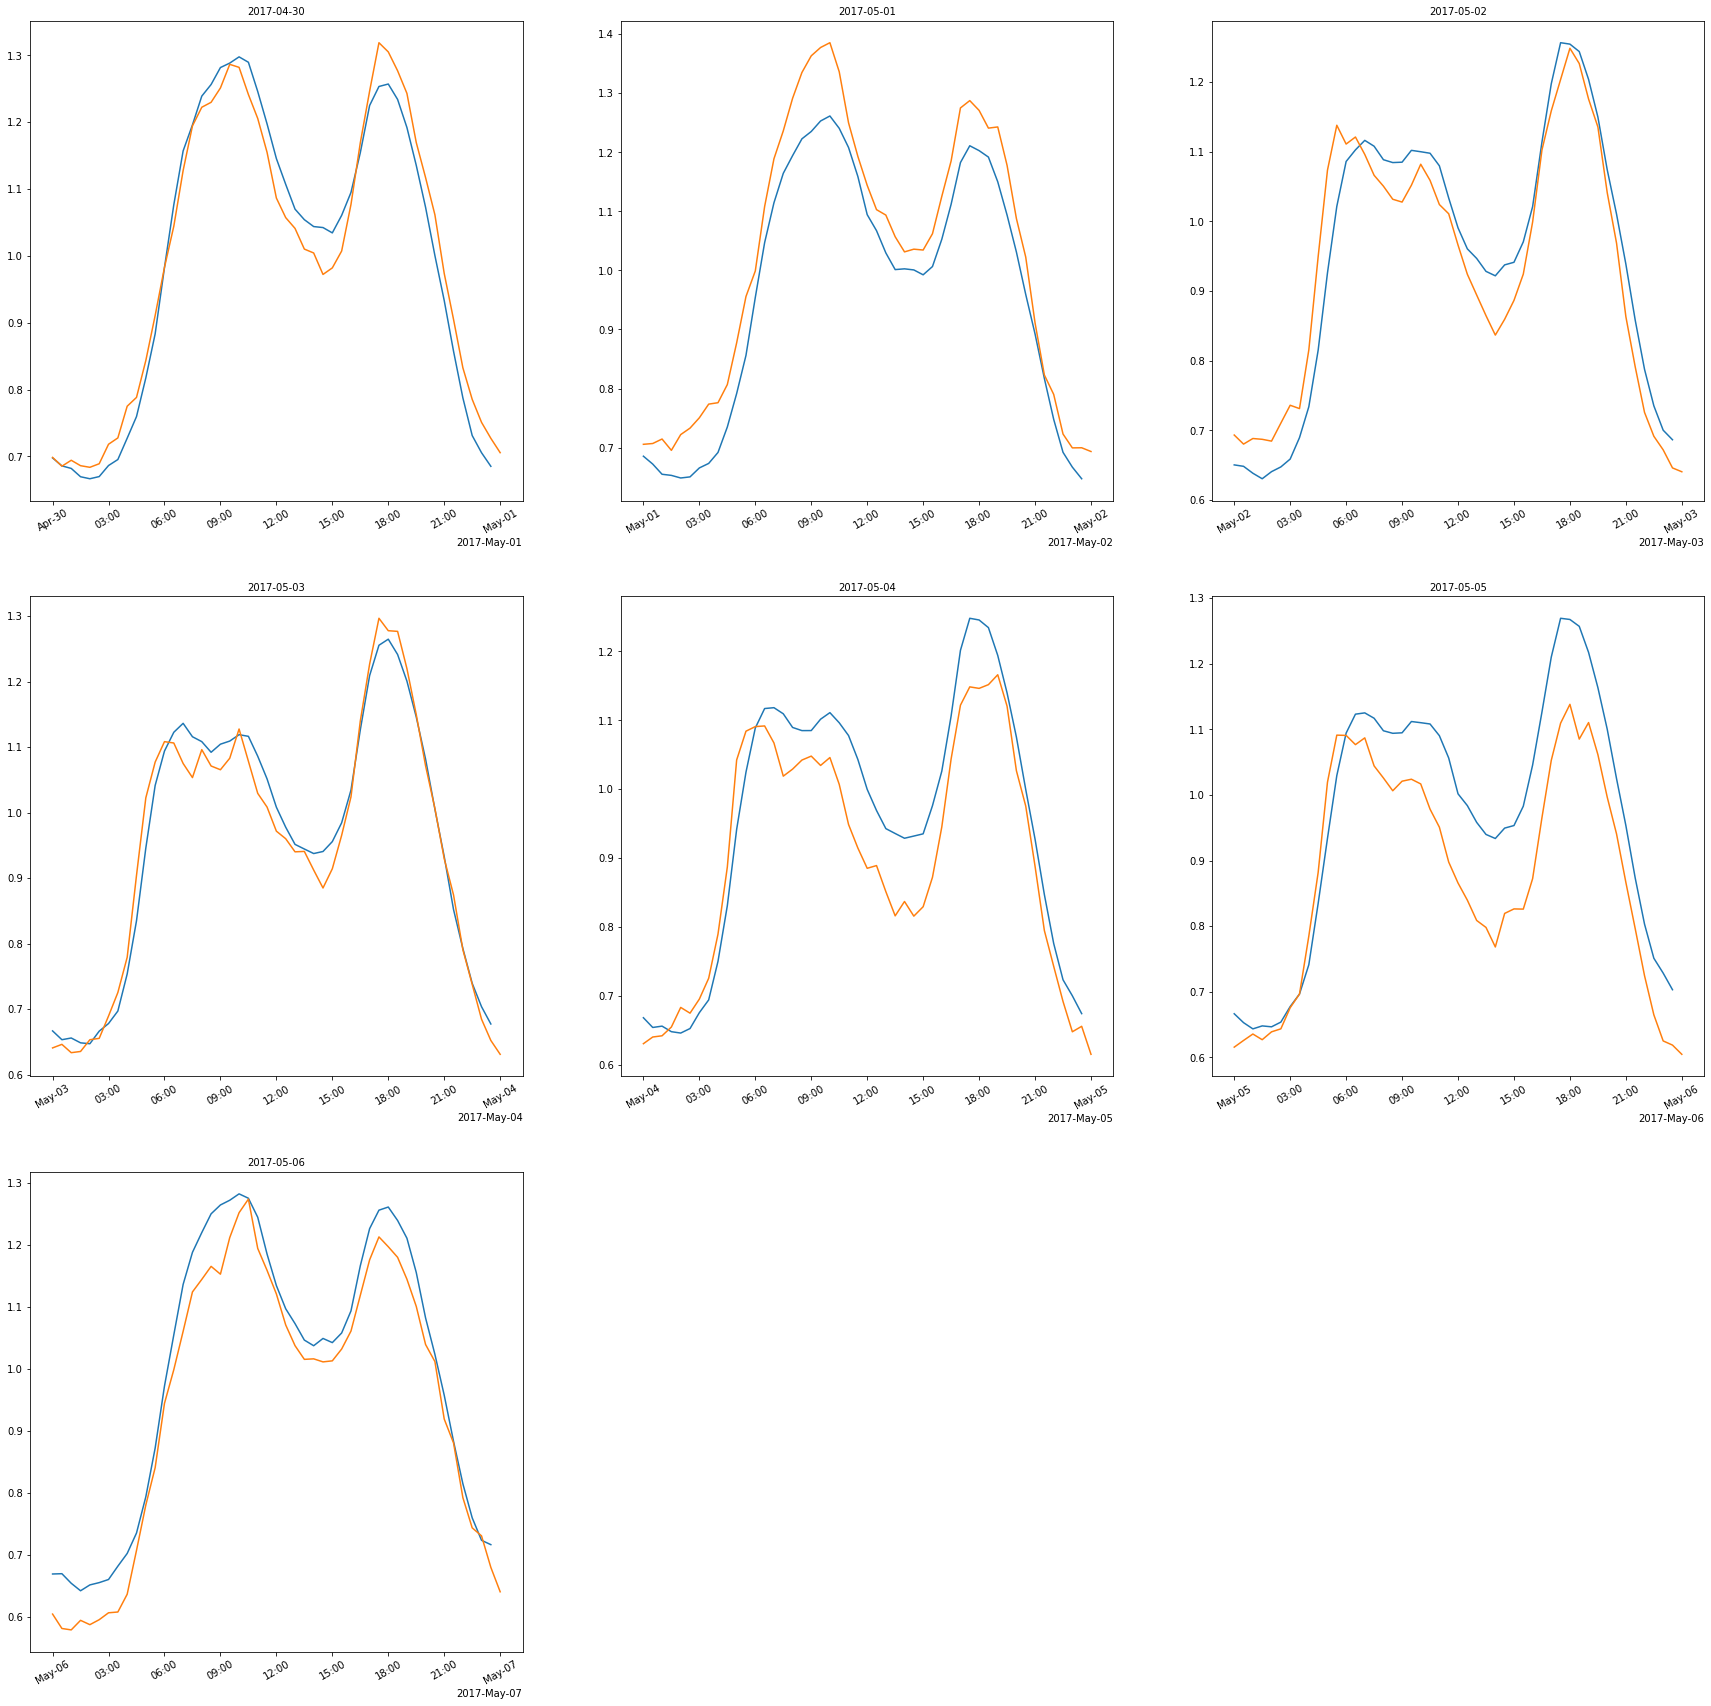

In [20]:
import pytz
from matplotlib.dates import (HourLocator, AutoDateLocator, DateFormatter,
                              ConciseDateFormatter, rrulewrapper, RRuleLocator, drange)


paris=pytz.timezone('Europe/Paris')
locator = AutoDateLocator()
formatter=ConciseDateFormatter(locator,tz=paris)


fig=plt.figure(figsize=(30,30)) 
for i in range(7) :
        
        ax=fig.add_subplot(3,3,i+1)
        ax.plot_date(forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['ds'],forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['yhat'],linestyle='-',marker=None);
        ax.plot_date(y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')].index,
                     y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')]['RES11_BASE'],linestyle='-',marker=None)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_tick_params(rotation=30, labelsize=10)
        ax.set_title(date(2017,4,30)+48*i*pd.Timedelta('30m'),fontsize=10)

In [21]:
df.tail()

,special_days,offpeak,peak,ds,y,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
Horodate_UTC,,,,,,,,,,
2017-04-29 22:00:00,0,False,True,2017-04-29 22:00:00,0.840376,False,False,False,True,13.4
2017-04-29 22:30:00,0,False,True,2017-04-29 22:30:00,0.766005,False,False,False,True,13.4
2017-04-29 23:00:00,0,False,True,2017-04-29 23:00:00,0.743610,False,False,False,True,13.4
2017-04-29 23:30:00,0,False,True,2017-04-29 23:30:00,0.727882,False,False,False,True,13.4
2017-04-30 00:00:00,0,False,True,2017-04-30 00:00:00,0.698508,False,False,False,True,13.3


## Regressor is added to the dataset

In [22]:
# copy of the temperature (columns 18 from X_train) is added to the dataset in column 'temp'
df['temp'] = X_train.iloc[0:,18:19]

df.head()

,special_days,offpeak,peak,ds,y,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
Horodate_UTC,,,,,,,,,,
2013-10-13 22:00:00,0,False,True,2013-10-13 22:00:00,0.698925,False,False,False,True,9.6
2013-10-13 22:30:00,0,False,True,2013-10-13 22:30:00,0.722778,False,False,False,True,9.6
2013-10-13 23:00:00,0,False,True,2013-10-13 23:00:00,0.678717,False,False,False,True,9.6
2013-10-13 23:30:00,0,False,True,2013-10-13 23:30:00,0.668509,False,False,False,True,9.5
2013-10-14 00:00:00,0,False,True,2013-10-14 00:00:00,0.700487,False,False,True,False,9.5


In [23]:
X_full=pd.concat([X_train,X_test],axis=0,sort=True).sort_index()

def weather_temp(df):
    columns = list(X_full.columns.values.tolist()) 
    if isinstance(df.index, pd.DatetimeIndex):
        list_date = df.index.tolist()
        count = 0
        for d in list_date:
            df.at[d, 'temp'] = X_full.loc[d,columns[19]]
            count = count + 1
    return df

## Creation of the Prophet model with custom seasonality an regressor
internal daily seasonality is desactivated

In [24]:
m = Prophet(daily_seasonality=False)

m.add_seasonality(name='winter_on_work', period=1, fourier_order=12, condition_name='winter_on_work')
m.add_seasonality(name='winter_off_work', period=1, fourier_order=12, condition_name='winter_off_work')
m.add_seasonality(name='summer_on_work', period=1, fourier_order=12, condition_name='summer_on_work')
m.add_seasonality(name='summer_off_work', period=1, fourier_order=12, condition_name='summer_off_work')

m.add_regressor(name='temp')
m.add_regressor(name='special_days')
# m.add_regressor(name='offpeak_hours')


Model training

In [25]:
m.fit(df)


### Preparation of future dataset for the forecast
creation of the seasonality and regressors columns

In [26]:
future = m.make_future_dataframe(periods=7*48, freq = '30T')

future['id']=future.index
future.index=future['ds']

future=seasonalize(future, **arguments).seasons_dataset()
future.special_days = future.special_days.astype(int)

future = weather_temp(future)
future.head()

# calendar.Dataframe(future)
# future=calendar.prophet_days_onoff()
future.index=future['id']
future=future.drop(["id"],axis=1)
future.head()

,special_days,offpeak,peak,ds,winter_on_work,winter_off_work,summer_on_work,summer_off_work,temp
id,,,,,,,,,
0,0,False,True,2013-10-13 22:00:00,False,False,False,True,9.6
1,0,False,True,2013-10-13 22:30:00,False,False,False,True,9.6
2,0,False,True,2013-10-13 23:00:00,False,False,False,True,9.6
3,0,False,True,2013-10-13 23:30:00,False,False,False,True,9.5
4,0,False,True,2013-10-14 00:00:00,False,False,True,False,9.5


## Forecast calculation
results are the plotted :
- components of the forecast :  trend, yealry seasonality, weekly seasonality, daily custom sesonality, regressor
- forecasted serie

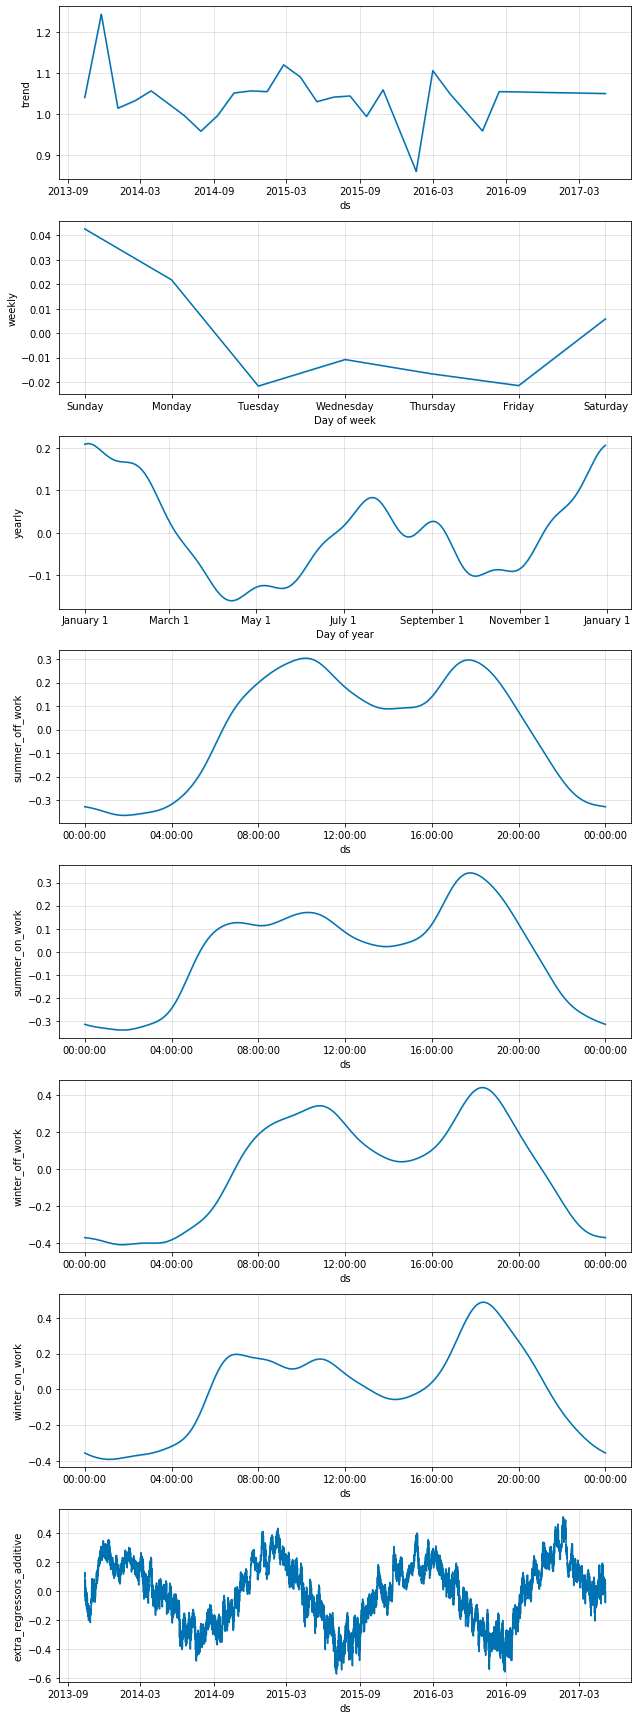

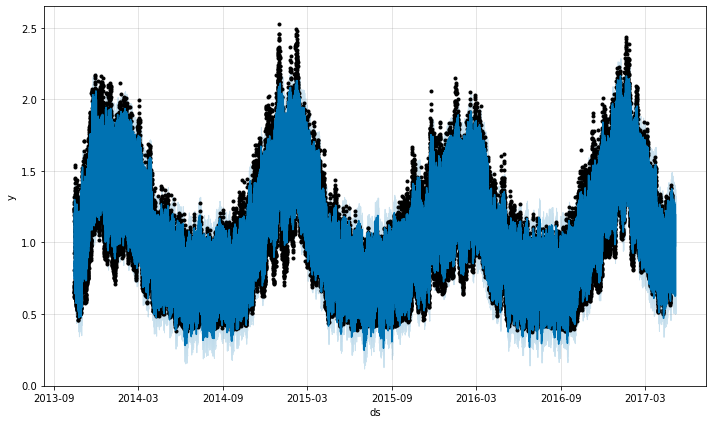

In [27]:

forecast = m.predict(future)

fig = m.plot_components(forecast)

fig = m.plot(forecast)

# Focus on the forecast and model evaluation

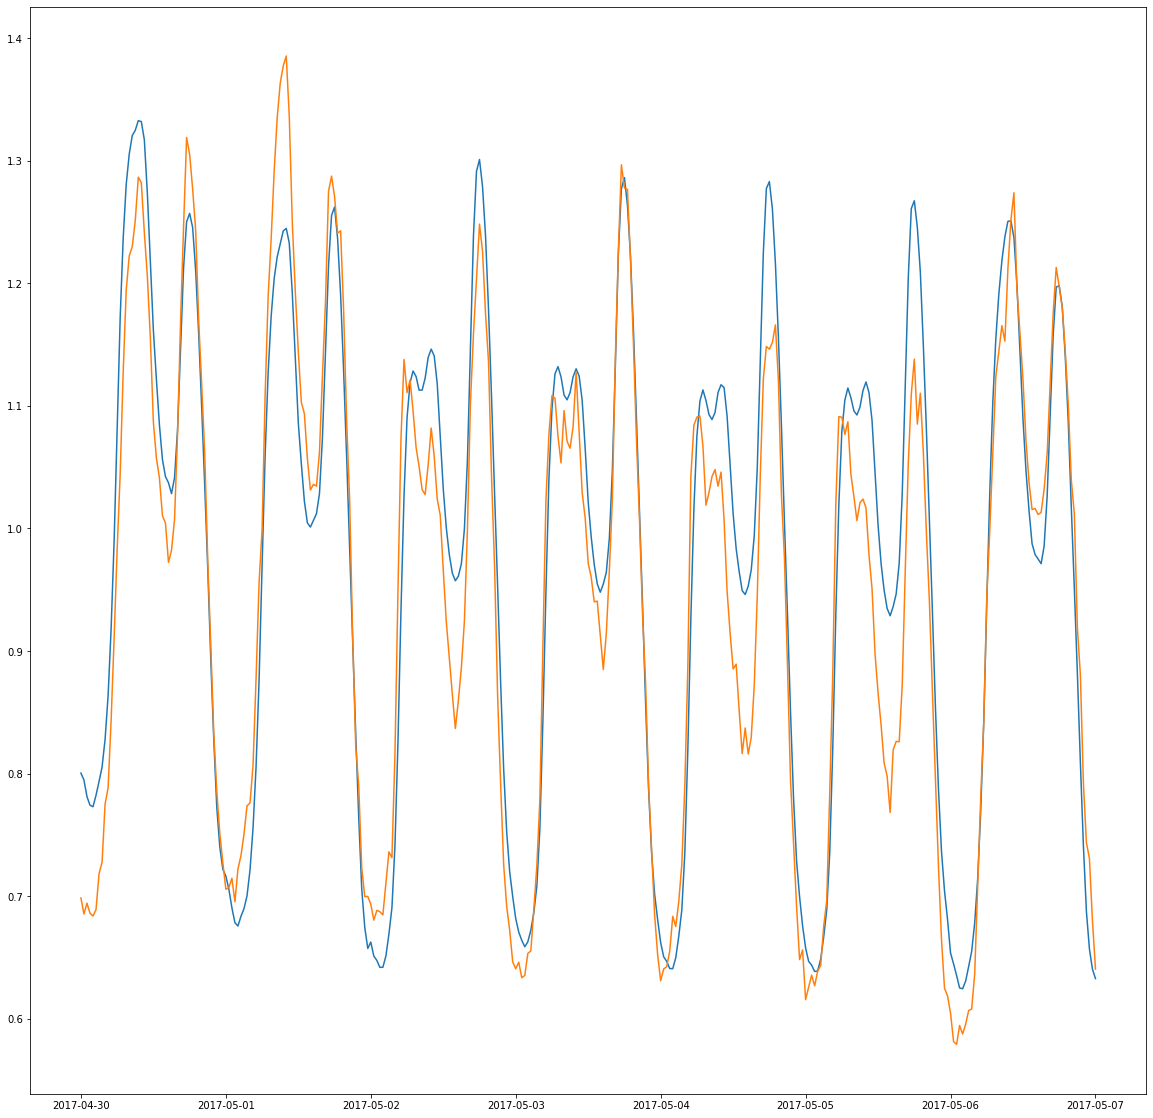

In [28]:
fig=plt.figure(figsize=(20,20))
id_max=forecast.shape[0]
plt.plot_date(forecast.iloc[id_max-(7*48+1):id_max]['ds'],forecast.iloc[id_max-(7*48+1):id_max]['yhat'],linestyle='-',marker=None)
plt.plot_date(y_train.loc[date(2017,4,30):date(2017,5,7)].index,y_train.loc[date(2017,4,30):date(2017,5,7)]['RES11_BASE'],linestyle='-',marker=None)

In [29]:
print('RMSE',rmse(forecast.iloc[id_max-(7*48+1):id_max]['yhat'],y_train.loc[date(2017,4,30):date(2017,5,7)]['RES11_BASE']))

print('MAPE %0.2f%%' %mape(np.array(y_train.loc[date(2017,4,30):date(2017,5,7)]['RES11_BASE']), np.array(forecast.iloc[id_max-(7*48+1):id_max]['yhat'])))

RMSE 0.06801303862770995
MAPE 6.04%


# Comparison of forecasted and real daily profiles

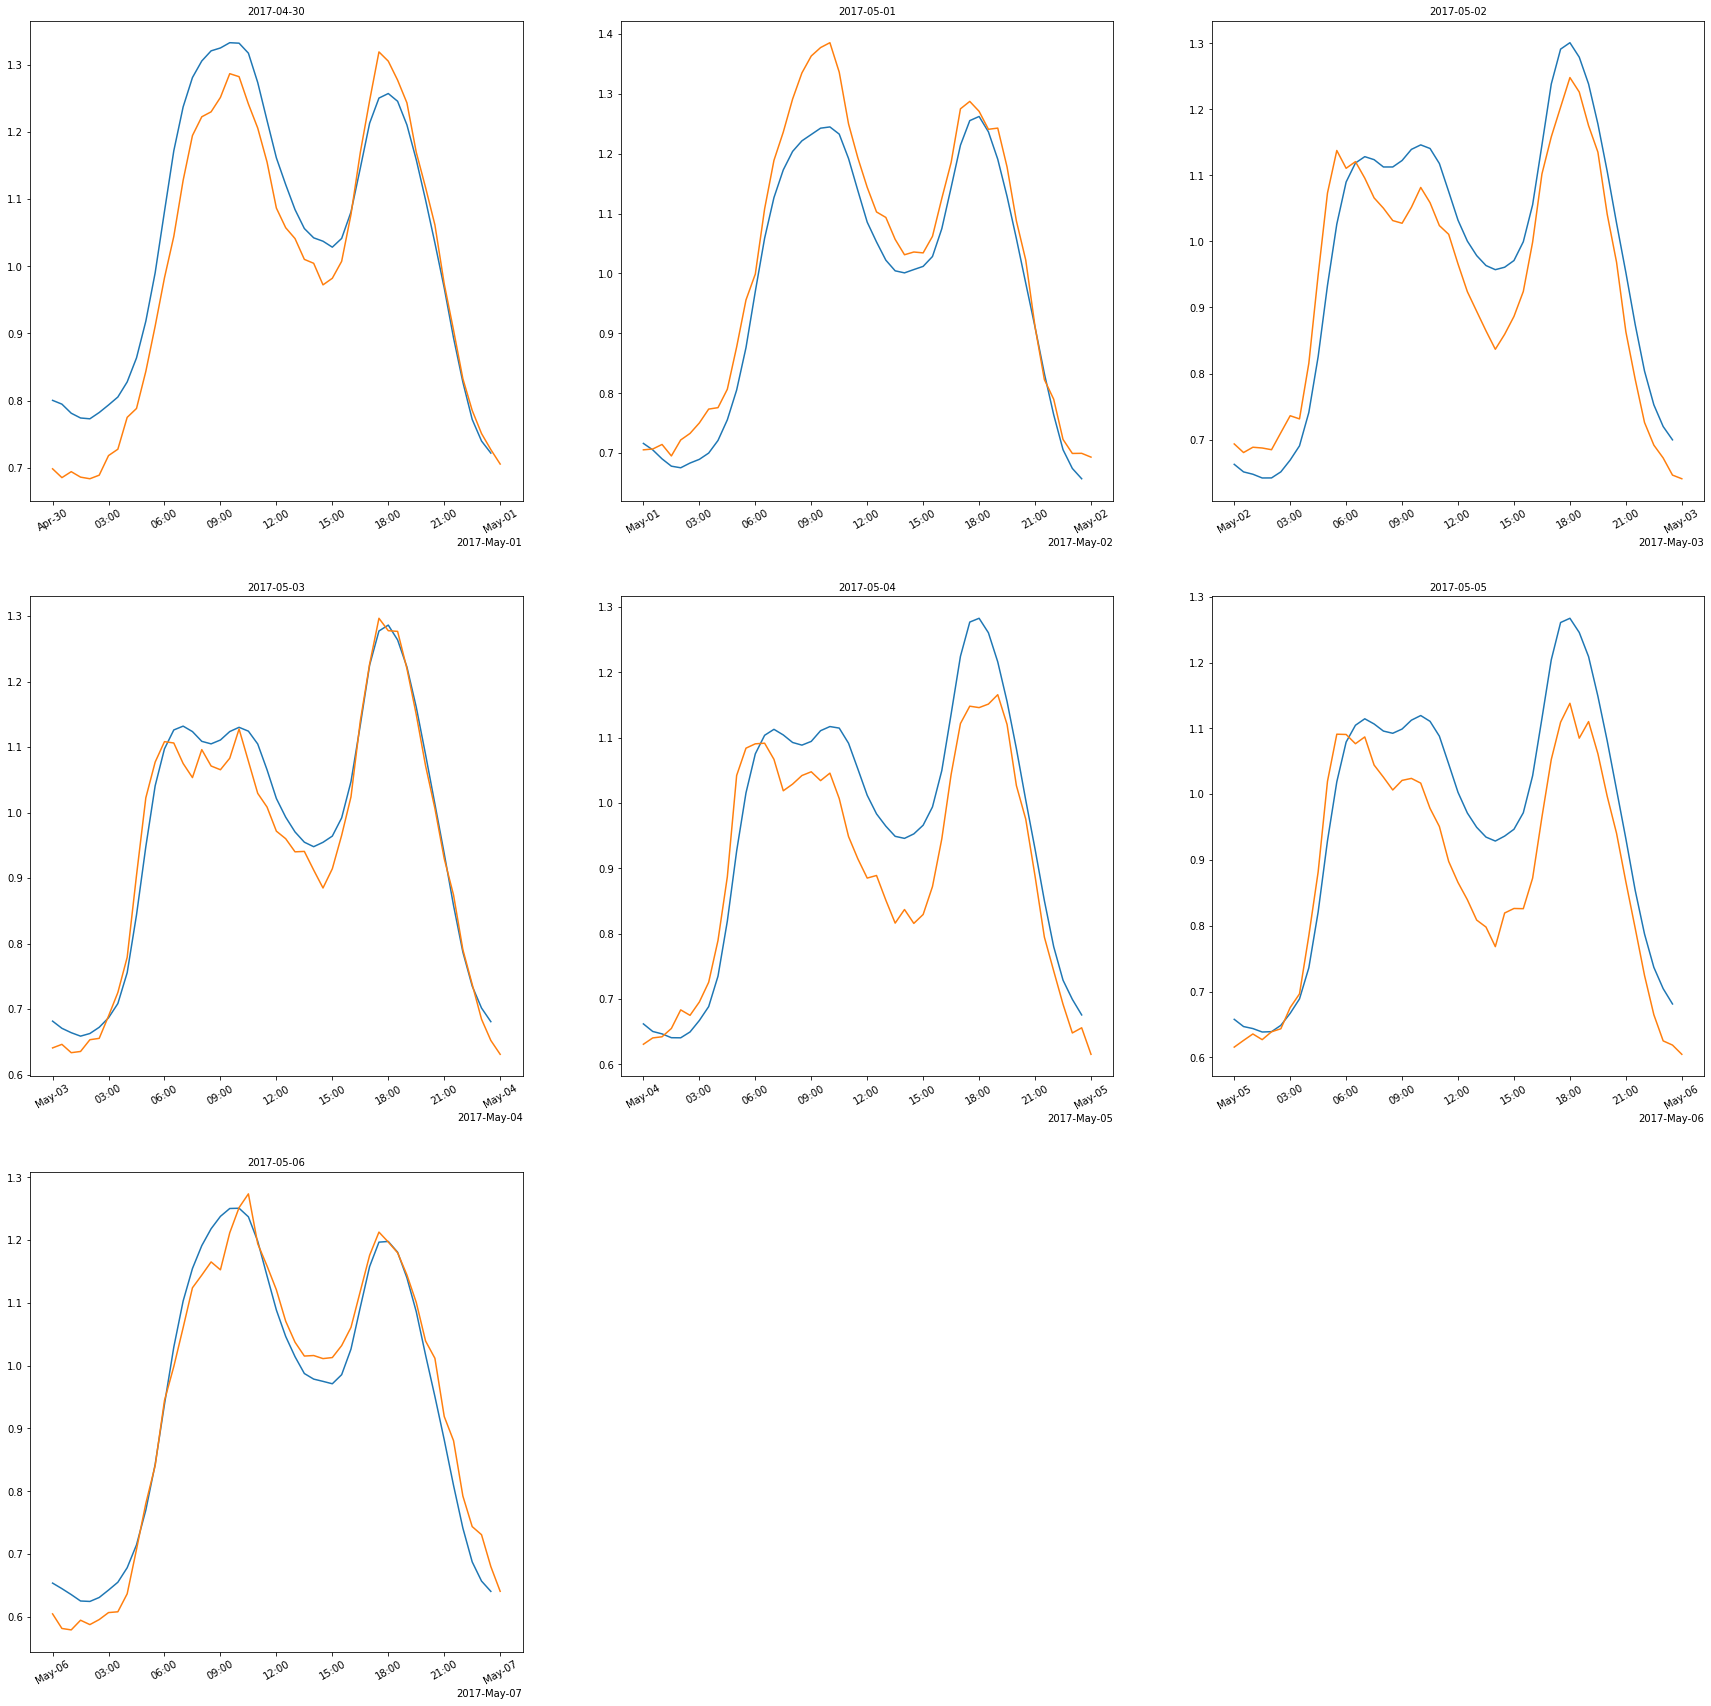

In [30]:
import pytz
from matplotlib.dates import (HourLocator, AutoDateLocator, DateFormatter,
                              ConciseDateFormatter, rrulewrapper, RRuleLocator, drange)


paris=pytz.timezone('Europe/Paris')
locator = AutoDateLocator()
formatter=ConciseDateFormatter(locator,tz=paris)


fig=plt.figure(figsize=(30,30)) 
for i in range(7) :
        
        ax=fig.add_subplot(3,3,i+1)
        ax.plot_date(forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['ds'],forecast.iloc[id_max-((7-i)*48+1):id_max-((6-i)*48+1)]['yhat'],linestyle='-',marker=None);
        ax.plot_date(y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')].index,
                     y_train.loc[date(2017,4,30)+48*i*pd.Timedelta('30m'):date(2017,4,30)+48*(i+1)*pd.Timedelta('30m')]['RES11_BASE'],linestyle='-',marker=None)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_tick_params(rotation=30, labelsize=10)
        ax.set_title(date(2017,4,30)+48*i*pd.Timedelta('30m'),fontsize=10)